In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import r2_score
import pickle
import time
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy import sparse
import os.path
from scipy.interpolate import splrep, splev
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
sys.path.append('../..')
from CIMatrixLib.src.util import *
from CIMatrixLib.src.TreatPattern import *
from CIMatrixLib.src.algorithms.DebiasConvex import *
from CIMatrixLib.src.algorithms.CovariancePCA import *
from CIMatrixLib.src.algorithms.MCNNM import *
from CIMatrixLib.src.algorithms.RobustSyntheticControl import *
import CIMatrixLib.src.readData as readData
import importlib

In [4]:
def check_distribution(n1, n2, mean_M = 1, tau_star = 1, sigma = 1, r = 5, num_experiment=10, file_path = 'data.p'):
    np.random.seed(1)    

    U = np.random.gamma(shape=1, scale=2, size=(n1, r))
    V = np.random.gamma(shape=1, scale=2, size=(n2, r))
    M0 = U.dot(V.T)
    M0 = M0 / np.mean(M0) * mean_M #since we take mean here, we want M0 to be positive

    #Z = adpative_treatment_pattern(10, 10, M0)

    Z = np.zeros((n1, n2))
    m1 = 1
    m2 = 0
    Z[:m1, m2:] = 1

    i = 0
    j = 0

    ZTperp = projection_T_orthogonal(Z, M0)
    ZT = Z - ZTperp
    Z_induced_error = ZT[i, j]**2 / np.sum(ZTperp**2)
    
    u, s, vh = np.linalg.svd(M0, full_matrices = False)
    M_induced_error_u = np.sum(u[i, :r]**2)
    M_induced_error_v = np.sum(vh[:r, j]**2)
    M_induced_overlap = np.sum(u[i, :r]**2)*np.sum(vh[:r, j]**2)

    variance_debias = sigma**2 / np.sum(ZTperp**2)
    variance_ideal = sigma**2 / np.sum(Z**2)

    print(Z_induced_error, M_induced_error_u,  M_induced_error_v, M_induced_overlap)
    data = np.zeros((2, num_experiment))
    #store 
    for index_exp in range(num_experiment):
        if (index_exp % 100 == 0):
            print('experiments', index_exp)
        E = np.random.normal(loc = 0, scale = sigma, size = (n1, n2))
        #print('sparsity is ', np.sum(Z) / Z.size)    
        O = M0 + E + Z * tau_star

        u, s, vh = np.linalg.svd(M0 + E, full_matrices = False)
        suggest_lambda = 1.1*s[r]

        M_debias, tau_debias = tune_convex_algorithm_with_PTperp(O, Z, suggest_lambda = -1, debias_flag=True)
        #print(M_debias[i, j] - M0[i, j])
        data[0, index_exp] = M_debias[i, j] - M0[i, j]
        data[1, index_exp] = tau_debias - tau_star
    return data, Z_induced_error, M_induced_error_u, M_induced_error_v, M_induced_overlap, variance_debias, variance_ideal
        #data[i,0] = M_debias[0, 0] - M0[0, 0]
        #data[i,1] = ideal_algorithm(E, Z)

In [9]:
sigma = 0.1
mean_M = 10
data, eZ, eMu, eMv, eMuv, variance_debias, variance_ideal = check_distribution(50, 50, mean_M = mean_M, sigma = sigma, num_experiment=1000)

054084447, PVZ 44.31377604097379, PTperZ 5.5738848026012775, Z 50.0
PUVZ 4.176032429895239, PUZ 4.656484467648937, PVZ 44.84104326889036, PTperZ 4.678504693355871, Z 50.0
PUVZ 4.058857741389552, PUZ 4.517750510940479, PVZ 44.92122497203377, PTperZ 4.619882258415277, Z 50.0
PUVZ 1.8939519465308767, PUZ 2.1305387111248626, PVZ 44.44772433942131, PTperZ 5.3156888959847075, Z 50.0
PUVZ 0.806400456349615, PUZ 0.9147003320506493, PVZ 44.080035181673196, PTperZ 5.811664942625761, Z 50.0
PUVZ 2.235969845238299, PUZ 2.51226277969751, PVZ 44.50111396204187, PTperZ 5.222593103498952, Z 50.0
PUVZ 4.543097377565383, PUZ 5.09893133672384, PVZ 44.549505352668774, PTperZ 4.89466068817276, Z 50.0
PUVZ 2.8208146072343467, PUZ 3.1899377982850963, PVZ 44.214257230200715, PTperZ 5.4166195787486275, Z 50.0
PUVZ 3.5138715088966217, PUZ 3.9723707359135303, PVZ 44.22889682889247, PTperZ 5.312603944090682, Z 50.0
PUVZ 0.9443368393521633, PUZ 1.0557664138720368, PVZ 44.7228111703609, PTperZ 5.165759255119304, Z 

In [10]:
variance = sigma**2 * (eZ + eMu + eMv - eMuv)
print(np.sqrt(variance))
print(np.std(data[0, :]), np.mean(data[0, :]))

0.07533231993928582
0.0809422829002183 -0.00762386369636473


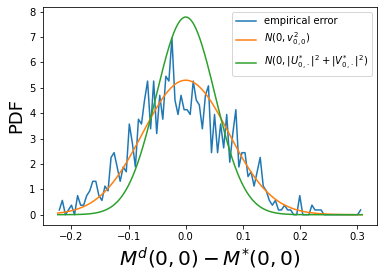

In [11]:
data_M = data[0, :] 
hist, bined = np.histogram(data_M, bins = 100, density=True)
plt.plot((bined[:-1]/2+bined[1:]/2), hist)
pos_guassian = np.linspace(min(data_M), max(data_M), 1000)
pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=np.sqrt(variance))
plt.plot(pos_guassian, pdf_guassian)


#hist, bined = np.histogram(data_ideal, bins = 100, density=True)
#plt.plot(bined[:-1]/2+bined[1:]/2, hist)
pos_guassian = np.linspace(min(data_M), max(data_M), 1000)
pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=np.sqrt(variance-sigma**2*eZ+sigma**2*eMuv))
plt.plot(pos_guassian, pdf_guassian)

plt.ylabel('PDF', fontsize = 18)
plt.xlabel(r'$M^{d}(0, 0) - M^{*}(0,0)$', fontsize=20)
plt.legend([r'empirical error', r'$N(0, v_{0,0}^2)$', r'$N(0, \|U^{*}_{0,\cdot}\|^2 + \|V^{*}_{0,\cdot}\|^2$)'])
#plt.show()
#plt.hist(data_ideal, bins = 30)

## Plot of tau

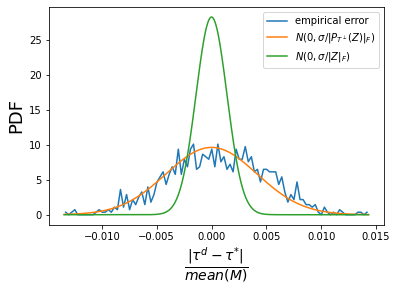

In [12]:
#pickle.dump([data, variance_debias, variance_ideal], open(file_path, 'wb'))
data_debias = data[1, :]
mean_M = 10
hist, bined = np.histogram(data_debias, bins = 100, density=True)
plt.plot((bined[:-1]/2+bined[1:]/2)/mean_M, hist)
pos_guassian = np.linspace(min(data_debias), max(data_debias), 1000)
pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=np.sqrt(variance_debias))
plt.plot(pos_guassian/mean_M, pdf_guassian)


#hist, bined = np.histogram(data_ideal, bins = 100, density=True)
#plt.plot(bined[:-1]/2+bined[1:]/2, hist)
pos_guassian = np.linspace(min(data_debias), max(data_debias), 1000)
pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=np.sqrt(variance_ideal))
plt.plot(pos_guassian / mean_M, pdf_guassian)

plt.ylabel('PDF', fontsize = 18)
plt.xlabel(r'$\frac{|\tau^{d} - \tau^{*}|}{mean(M)}$', fontsize=20)
plt.legend([r'empirical error', r'$N(0, \sigma/\|P_{T^{\perp}}(Z)\|_{F})$', r'$N(0, \sigma/\|Z\|_{F})$'])
#plt.show()
#plt.hist(data_ideal, bins = 30)